# **Step 1: Installing Python Modules**

We need to import necessary modules to kicktstart the data visualization project
- "matplotlib" includes some basic chart plotting functions and it is widely used in statistical researches
- "plotly" contains interactive chart plotting functions and it is widely used in business analytics

---

In [1]:
import requests
from bs4 import BeautifulSoup 
import pandas as pd 

!pip install plotly==4.5.0
import matplotlib.pyplot as plt   
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10)

     |████████████████████████████████| 7.1MB 5.0MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy



The web scraper function that we have developed in the previous project will be used here for extracting stock data.

In [2]:
def scrape_table(Url):
    soup = BeautifulSoup(requests.get(Url).text)
    headers = [header.text for listing in soup.find_all('thead') for header in listing.find_all('th')]
    raw_data = {header:[] for header in headers}

    for rows in soup.find_all('tbody'):
      for row in rows.find_all('tr'):
        if len(row) != len(headers) or row.find_all('td')[3].text == '-': 
          continue
        for idx, cell in enumerate(row.find_all('td')):
          raw_data[headers[idx]].append(cell.text)

    return pd.DataFrame(raw_data)

# **Step 2: Data Type Conversion**


The data type conversion functions in the previous project Wrangling will be used here for data conversion as well.

In [3]:
def convert_column_to_float(df, columns):
  for column in columns: 
    df[column] = pd.to_numeric(df[column].str.replace(',',''))
  return df

def convert_column_to_datetime(df, columns):
  for column in columns:
    df[column] = pd.to_datetime(df[column])
  return df

def revert_scaled_number(number):
  mapping = {'M': 1000000, 'B': 1000000000, 'T': 1000000000000}
  scale = number[-1]
  return float(number[0:-1]) * mapping[scale]

# **Step 3: Basic Chart Types**

Let's extract some stock data! Let's use Apple Inc. as an example. We only want to keep the prices for the latest 90 days. Then, we convert the data into the right format and the following table shows each date's open, close, low and high price.

In [4]:
apple = scrape_table("https://finance.yahoo.com/quote/AAPL/history?p=AAPL")[0:90]
apple = convert_column_to_float(apple, apple.columns[1:])
apple = convert_column_to_datetime(apple, [apple.columns[0]])
apple

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2021-01-28,139.52,141.99,138.00,140.82,140.82,81275183
1,2021-01-27,143.43,144.30,140.41,142.06,142.06,139236700
2,2021-01-26,143.60,144.30,141.37,143.16,143.16,98390600
3,2021-01-25,143.07,145.09,136.54,142.92,142.92,157611700
4,2021-01-22,136.28,139.85,135.02,139.07,139.07,113907200
...,...,...,...,...,...,...,...
85,2020-09-25,108.43,112.44,107.67,112.28,112.09,149981400
86,2020-09-24,105.17,110.25,105.00,108.22,108.03,167743300
87,2020-09-23,111.62,112.11,106.77,107.12,106.94,150718700
88,2020-09-22,112.68,112.86,109.16,111.81,111.62,183055400


Using "Date" as X-axis, "Price" as Y-axis, use Matplotlib to draw the stock movement graph.

References：
*   lw = linewidth (The width of the line)
*   kind (The mark on the line)
*   grid (Whether to use grid cells)
*   title (Add title to the graph)


Text(0, 0.5, 'Price (USD)')

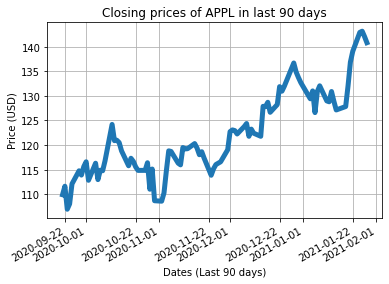

In [5]:
ts = pd.Series(apple["Adj Close**"].values, index=apple["Date"])
ts.plot(lw=5, kind='line', grid=True, title='Closing prices of APPL in last 90 days')
plt.xlabel('Dates (Last 90 days)') 
plt.ylabel('Price (USD)') 

Let's create a pie chart with the use of filtering function.

- You have learnt how to filter dataframes in previous sessions. Let's use them to create a pie chart
- The pie chart should show the percentage distribution of market capitalization of different cryptocurrencies

In [6]:
df=scrape_table("https://finance.yahoo.com/cryptocurrencies?count=200&offset=0")
df['Market Cap']=df['Market Cap'].apply(revert_scaled_number)
market_cap_sum = sum(df['Market Cap'])
df.loc[df['Market Cap']/market_cap_sum < 0.01, 'Name'] = 'Others'

fig = px.pie(df, values='Market Cap', names='Name', title='Market Share of Cryptocurrencies')
fig.show()

**Candle Stick Charts**

Use Plotly to draw the candlestick graph (Move cursor on the graph to show hover data).

References：


*   autosize (Auto zoom-in and out)
*   margin (Adjust the margin of the graph; l:left, r:right, t:top, b:bottom)
*   paper_bgcolor (Change background color of the graph)


In [7]:
fig = go.Figure(data=[go.Candlestick(
                          x=apple['Date'],
                          open=apple['Open'],
                          high=apple['High'],
                          low=apple['Low'],
                          close=apple['Close*'])],
                )
fig.update_layout(
    autosize=True,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

# fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

#Step 4: Advanced chart types

**Multi-stock area graph**
- Using the web scraper to obtain data from various stocks 
- Then, stack them together in an area chart/line chart.

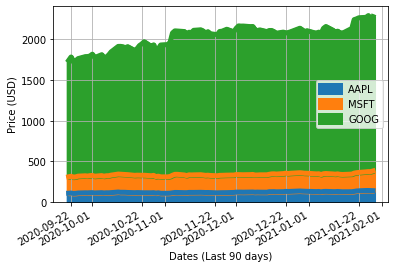

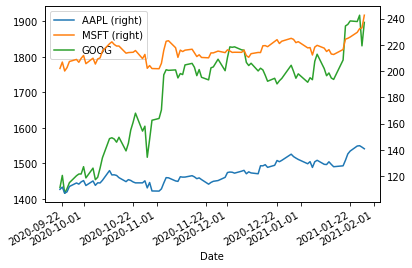

In [8]:
microsoft, google = (scrape_table("https://finance.yahoo.com/quote/"+s+"/history?p="+s)[0:90] for s in ["MSFT", "GOOG"])
microsoft, google = convert_column_to_float(microsoft, microsoft.columns[1:]), convert_column_to_float(google, google.columns[1:])
microsoft, google = convert_column_to_datetime(microsoft, [microsoft.columns[0]]), convert_column_to_datetime(google, [google.columns[0]])
 
stocks = pd.DataFrame({"AAPL": apple["Adj Close**"].values,
                       "MSFT": microsoft["Adj Close**"].values,
                       "GOOG": google["Adj Close**"].values},
                      index=apple["Date"])
stocks.plot(lw=5, kind='area', grid=True)
plt.xlabel('Dates (Last 90 days)') 
plt.ylabel('Price (USD)') 

stocks.plot(secondary_y = ["AAPL", "MSFT"], kind='line')

**Heatmaps**

- The rectangle area represents market capitalization
- The color gradient represents percentage price change (positive, negative)
- Ticker symbol is shown on each rectangle
- Hovering over the square will show the underlying details of a stock

In [9]:
activestocks = scrape_table("https://finance.yahoo.com/most-active?count=200&offset=0")
marketCaps = activestocks['Market Cap'].apply(revert_scaled_number)
percentChanges = activestocks['% Change'].str.replace('+','').str.replace('%','').astype(float)

In [10]:
fig = px.treemap(activestocks,  
                  title='Active Stocks Heatmap (Size=Market Cap, Color=Percent Change)',
                  path=['Symbol'],
                  values=marketCaps, 
                  hover_name='Name',
                  hover_data=['Price (Intraday)', '% Change', 'Volume', 'Market Cap', 'PE Ratio (TTM)'],
                  color=percentChanges, 
                  color_continuous_scale='RdYlGn',
                  range_color=[-5,5])

fig.update_layout(
    autosize=True,
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="White",
)

fig.show()

**Bubble Charts**
- Bubble chart is a type of 3-dimensional data visualization
- It visualizes percentage price change (y-axis), daily price (x-axis) and market cap (circle area) in one view

In [12]:
activestocks = scrape_table("https://finance.yahoo.com/most-active?count=200&offset=0")
activestocks['Market Cap']=activestocks['Market Cap'].apply(revert_scaled_number)
activestocks['% Change']=activestocks['% Change'].str.replace('+','').str.replace('%','').astype(float)
activestocks['Price (Intraday)']=activestocks['Price (Intraday)'].str.replace(',','').astype(float)


fig2 = px.scatter(activestocks, x="Price (Intraday)", y="% Change",
	        size="Market Cap", color="Name",
          hover_name="Name", size_max=60)

fig2.update_layout(
    autosize=True,
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="White",
)

fig2.show()